# Arxiv Tool 테스트
arxiv_tool의 기본 동작, max_results 옵션, LangGraph agent 연동까지 순서대로 테스트합니다.

## 0. load env

In [3]:
import os
import sys

from dotenv import load_dotenv, find_dotenv

# Load environment variables
dotenv_path = find_dotenv()
print(f"Target .env path: {dotenv_path}")
loaded = load_dotenv(dotenv_path, override=True)
print(f"Loading successful: {loaded}")

# Add project root to path
sys.path.append(os.path.abspath('../../../../..'))

Target .env path: /Users/kimjunghyeon/Desktop/workspace/ai-agent/.env
Loading successful: True


## 1. 기본 검색 테스트

In [4]:
from app.agents.tools.arxiv import arxiv_tool

query = "LangGraph multi-agent systems"
result = arxiv_tool.invoke({"query": query})
print(result)

Published: 2024-10-18
Title: A Survey of Multi-Agent Deep Reinforcement Learning with Communication
Authors: Changxi Zhu, Mehdi Dastani, Shihan Wang
Summary: Communication is an effective mechanism for coordinating the behaviors of multiple agents, broadening their views of the environment, and to support their collaborations. In the field of multi-agent deep reinforcement learning (MADRL), agents can improve the overall learning performance and achieve their objectives by communication. Agents can communicate various types of messages, either to all agents or to specific agent groups, or conditioned on specific constraints. With the growing body of research work in MADRL with communication (Comm-MADRL), there is a lack of a systematic and structural approach to distinguish and classify existing Comm-MADRL approaches. In this paper, we survey recent works in the Comm-MADRL field and consider various aspects of communication that can play a role in designing and developing multi-agent r

## 2. max_results 옵션 테스트

In [5]:
# max_results = 1
result_1 = arxiv_tool.invoke({"query": query, "max_results": 1})
print("=== max_results=1 ===")
print(result_1)
print(f"\n글자수: {len(result_1)}")

=== max_results=1 ===
Published: 2024-10-18
Title: A Survey of Multi-Agent Deep Reinforcement Learning with Communication
Authors: Changxi Zhu, Mehdi Dastani, Shihan Wang
Summary: Communication is an effective mechanism for coordinating the behaviors of multiple agents, broadening their views of the environment, and to support their collaborations. In the field of multi-agent deep reinforcement learning (MADRL), agents can improve the overall learning performance and achieve their objectives by communication. Agents can communicate various types of messages, either to all agents or to specific agent groups, or conditioned on specific constraints. With the growing body of research work in MADRL with communication (Comm-MADRL), there is a lack of a systematic and structural approach to distinguish and classify existing Comm-MADRL approaches. In this paper, we survey recent works in the Comm-MADRL field and consider various aspects of communication that can play a role in designing and de

In [6]:
# max_results = 5
result_5 = arxiv_tool.invoke({"query": query, "max_results": 5})
print("=== max_results=5 ===")
print(result_5)
print(f"\n글자수: {len(result_5)}")

=== max_results=5 ===
Published: 2024-10-18
Title: A Survey of Multi-Agent Deep Reinforcement Learning with Communication
Authors: Changxi Zhu, Mehdi Dastani, Shihan Wang
Summary: Communication is an effective mechanism for coordinating the behaviors of multiple agents, broadening their views of the environment, and to support their collaborations. In the field of multi-agent deep reinforcement learning (MADRL), agents can improve the overall learning performance and achieve their objectives by communication. Agents can communicate various types of messages, either to all agents or to specific agent groups, or conditioned on specific constraints. With the growing body of research work in MADRL with communication (Comm-MADRL), there is a lack of a systematic and structural approach to distinguish and classify existing Comm-MADRL approaches. In this paper, we survey recent works in the Comm-MADRL field and consider various aspects of communication that can play a role in designing and de

## 3. LangGraph Agent 연동 테스트

In [7]:
from typing import Annotated, TypedDict

from langchain_core.messages import AnyMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition

from app.agents.core.agent_factory import build_agent, create_tool_node_with_fallback
from app.agents.tools.arxiv import arxiv_tool


# ── State ────────────────────────────────────────────────────────────────────
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# ── Agent & Tool Node ────────────────────────────────────────────────────────
tools = [arxiv_tool]

agent = build_agent(
    tools=tools,
    system_prompt="당신은 논문 검색 어시스턴트입니다. Arxiv에서 최신 논문을 검색해 답변합니다.",
)

tool_node = create_tool_node_with_fallback(tools)

# ── Graph ────────────────────────────────────────────────────────────────────
workflow = StateGraph(State)
workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "tools",
        END: END
    }
)
workflow.add_edge("tools", "agent")

app = workflow.compile()
print("✅ Graph 컴파일 완료")

# ── 실행 ─────────────────────────────────────────────────────────────────────
query = "LangGraph multi-agent systems 최신 논문 찾아줘"  # 검색 필요 질문
# query = "논문 검색이 뭐야?"  # 검색 불필요 질문
async for chunk in app.astream(
        {"messages": [HumanMessage(content=query)]},
        stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

/Users/kimjunghyeon/Desktop/workspace/ai-agent/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Graph 컴파일 완료
================================ Human Message =================================

LangGraph multi-agent systems 최신 논문 찾아줘
================================== Ai Message ==================================
Tool Calls:
  arxiv_tool (call_8UYSppQtpwkh4mr1AJHTYlFj)
 Call ID: call_8UYSppQtpwkh4mr1AJHTYlFj
  Args:
    query: LangGraph multi-agent systems
    max_results: 3
================================= Tool Message =================================
Name: arxiv_tool

Published: 2024-10-18
Title: A Survey of Multi-Agent Deep Reinforcement Learning with Communication
Authors: Changxi Zhu, Mehdi Dastani, Shihan Wang
Summary: Communication is an effective mechanism for coordinating the behaviors of multiple agents, broadening their views of the environment, and to support their collaborations. In the field of multi-agent deep reinforcement learning (MADRL), agents can improve the overall learning performance and achieve their objectives by communication. Agents can communicate va

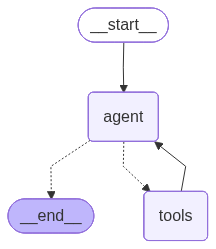

In [8]:
# Graph 시각화
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())